<center><h1>Theoretical guidelines for high-dimentional data analysis</h1></center> <center><h1>M2 Data Science</h1></center>
<br/>
<center><h3>Numerical implementation on the paper: False Discoveries occur Early on the Lasso Path</h3></center>

<center><h3>Colin de Verdière Matthieu and Houzé de l'Aulnoit Arnaud</h3></center>

<h3>Implementation of a representation of the true and false positive along the Lasso path</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, enet_path, lars_path
from sklearn import linear_model

#First we generate the data similarly as in the reference paper

n = 1010 #number of samples
p = 1000 #number of features
epsilon = 0.2 #sparsity ratio
lmbd = np.linspace(0.001, 10, 1000) #define some lambdas 

beta = [] #define the betas (200 non-null and 800 null betas)
true_signal = 4
false_signal = 0
for i in range(p):
    if i<epsilon*p:
        beta.append(true_signal)
    else:
        beta.append(false_signal)
        
mu, sigma = 0, 1 # mean and standard deviation
X = np.random.normal(mu, sigma, n*p) #We use a Gaussian distribution
X = X.reshape((n, p))

y_true = X.dot(beta) #We define the true labels (without noise to simplify the problem at the beginning)

### In the first time we compare two ways of define the Lasso path

#### - using the pre-computed lasso path function

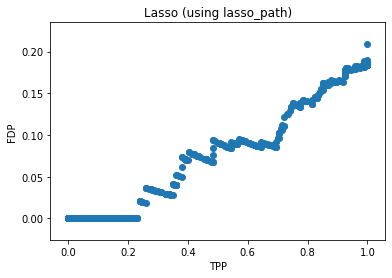

In [2]:
FDP_lasso_path = []
TPP_lasso_path = []

alphas_lasso, coefs_lasso, _ = lasso_path(X, y_true, alphas=lmbd)

for i in range(len(lmbd)):
    #FDP
    V = 0 #false discoveries
    D = 0 #number of estimated discoveries
    
    #TPP
    T = 0 #true discoveries
    k = epsilon*p #number of true signals
    
    for j in range (len(beta)):
        if (coefs_lasso[j][i] != 0):  #if the estimated beta is different from zero
            D = D+1
            if(beta[j] == 0): #if the true beta is different from zero
                V = V+1
            else:
                T = T+1
    
    FDP = V/max(D, 1)
    FDP_lasso_path.append(FDP)
        
    TPP = T/max(k, 1)
    TPP_lasso_path.append(TPP)
    
plt.scatter(TPP_lasso_path, FDP_lasso_path)
plt.title('Lasso (using lasso_path)')
plt.xlabel('TPP')
plt.ylabel('FDP')
plt.show()

#### - using a fit for each lambda

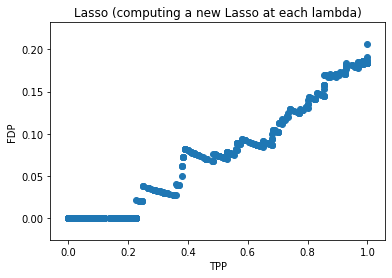

In [3]:
FDP_lasso_path = []
TPP_lasso_path = []
    
for i in range(len(lmbd)):
    
    clf = linear_model.Lasso(alpha=lmbd[i])
    clf.fit(X, y_true)

    #FDP
    V = 0 #false discoveries
    D = 0 #number of estimated discoveries
    
    #TPP
    T = 0 #true discoveries
    k = epsilon*p #number of true signals
    
    for j in range (len(beta)):
        if (clf.coef_[j] != 0): #if the estimated beta is different from zero
            D = D+1
            if(beta[j] == 0): #if the true beta is different from zero
                V = V+1
            else:
                T = T+1
        
    FDP = V/max(D, 1)
    FDP_lasso_path.append(FDP)
        
    TPP = T/max(k, 1)
    TPP_lasso_path.append(TPP)
    
plt.scatter(TPP_lasso_path, FDP_lasso_path)
plt.title('Lasso (computing a new Lasso at each lambda)')
plt.xlabel('TPP')
plt.ylabel('FDP')
plt.show()

## Lasso, Lars, Elastic net

In this section we compare three techniques of computing the Lasso via several $l_1$ regularizations

In [4]:
def ratio_path(coefs_path):
    FDP_path = []
    TPP_path = []

    for i in range(len(lmbd)):
        #FDP
        V = 0 #false discoveries
        D = 0 #number of estimated discoveries

        #TPP
        T = 0 #true discoveries
        k = epsilon*p #number of true signals

        for j in range (len(beta)):
            if (coefs_path[j][i] != 0): #if the estimated beta is different from zero
                D = D+1
                if(beta[j] == 0): #if the true beta is different from zero
                    V = V+1
                else:
                    T = T+1

        FDP = V/max(D, 1)
        FDP_path.append(FDP)

        TPP = T/max(k, 1)
        TPP_path.append(TPP)
    
    return TPP_path, FDP_path

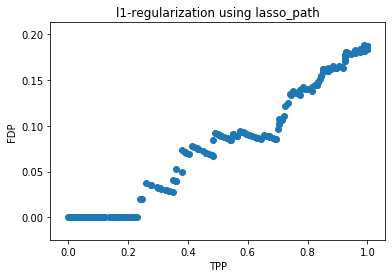

FDP mean :  0.15693391008851634
TPP mean :  0.86605


In [5]:
#Note we define the alphas with lasso_path in this section.
#We use the same alphas for Lasso, Lars and Elastic net.

alphas_lasso, coefs_lasso, _ = lasso_path(X, y_true, n_alphas=len(lmbd))

TPP_path, FDP_path = ratio_path(coefs_lasso)

plt.scatter(TPP_path, FDP_path)
plt.title('l1-regularization using lasso_path')
plt.xlabel('TPP')
plt.ylabel('FDP')
plt.show()

print('FDP mean : ', np.mean(FDP_path))
print('TPP mean : ', np.mean(TPP_path))

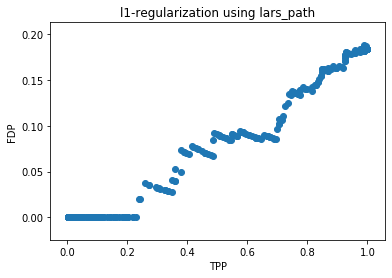

FDP mean :  0.15601803154197577
TPP mean :  0.86605


In [6]:
#LARS path

from sklearn.linear_model import lars_path
from scipy import interpolate

alphas_lars, active, coef_path_lars = lars_path(X, y_true, method='lasso')
coef_path_continuous = interpolate.interp1d(alphas_lars[::-1], coef_path_lars[:, ::-1], fill_value="extrapolate")
coefs_lars = coef_path_continuous(alphas_lasso)

TPP_path, FDP_path = ratio_path(coefs_lars)

plt.scatter(TPP_path, FDP_path)
plt.title('l1-regularization using lars_path')
plt.xlabel('TPP')
plt.ylabel('FDP')
plt.show()

print('FDP mean : ', np.mean(FDP_path))
print('TPP mean : ', np.mean(TPP_path))

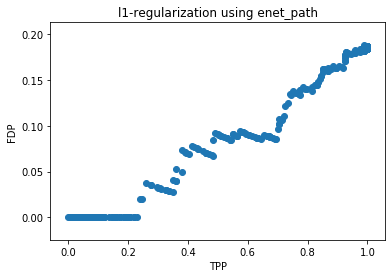

FDP mean :  0.15693391008851634
TPP mean :  0.86605


In [7]:
#Enet path

from sklearn.linear_model import lasso_path, enet_path

alphas_enet, coefs_enet, _ = enet_path(X, y_true, l1_ratio=1, alphas=alphas_lasso)

TPP_path, FDP_path = ratio_path(coefs_enet)
    
plt.scatter(TPP_path, FDP_path)
plt.title('l1-regularization using enet_path')
plt.xlabel('TPP')
plt.ylabel('FDP')
plt.show()

print('FDP mean : ', np.mean(FDP_path))
print('TPP mean : ', np.mean(TPP_path))

## Lasso with noise

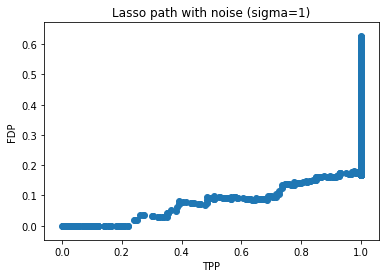

FDP mean :  0.2173957049469154
TPP mean :  0.866395


In [8]:
z = np.random.normal(mu, 0.5, n) #Define the noise
y_true = X.dot(beta) + z #Compute the new y_true

alphas_lasso_noise, coefs_lasso_noise, _ = lasso_path(X, y_true, n_alphas=len(lmbd))

TPP_path, FDP_path = ratio_path(coefs_lasso_noise)
    
plt.scatter(TPP_path, FDP_path)
plt.title('Lasso path with noise (sigma=1)')
plt.xlabel('TPP')
plt.ylabel('FDP')
plt.show()

print('FDP mean : ', np.mean(FDP_path))
print('TPP mean : ', np.mean(TPP_path))

<h3>Implementation of the boundary curve q*</h3>

In [9]:
# Code to calculate q* in suggested the reference paper and at https://github.com/wjsu/fdrlasso (in Matlab)

from scipy.stats import norm
from scipy.optimize import fminbound
from math import sqrt

def fdrlasso(tpp, delta, epsi):
    #--------------------------------------------------------------------------
    # This function calculates the Lasso trade-off curve given tpp (true
    # positive proportion), delta = n/p (shape of the design matrix, or
    # subsampling rate), and epsi = k/p (sparsity ratio).
    # All tpp, delta, and epsi are between 0 and 1; if the
    # pair (delta, epsi) is above the Donoho-Tanner phase transition, tpp
    # should be no larger than u^\star = powermax(delta, epsi)
    #--------------------------------------------------------------------------
    # Copyright @ Weijie Su, Malgorzata Bogdan, and Emmanuel Candes, 2015
    #--------------------------------------------------------------------------

    if tpp > powermax(delta, epsi):
        #print('Invalid input!')
        return

    if tpp == 0:
        q = 0
        return q

    ## make stepsize smaller for higher accuracy
    stepsize = 0.1
    tmax = max(10, sqrt(delta/epsi/tpp) + 1)
    tmin = tmax - stepsize

    while tmin > 0:
        if lsandwich(tmin, tpp, delta, epsi) < rsandwich(tmin, tpp):
            break
        tmax = tmin
        tmin = tmax - stepsize

    if tmin <= 0:
        stepsize = stepsize/100
        tmax = max(10, sqrt(delta/epsi/tpp) + 1)
        tmin = tmax - stepsize
        while tmin > 0:
            if lsandwich(tmin, tpp, delta, epsi) < rsandwich(tmin, tpp):
                break
            tmax = tmin
            tmin = tmax - stepsize

    diff = tmax - tmin
    while diff > 1e-6:
        tmid = 0.5*tmax + 0.5*tmin
        if lsandwich(tmid, tpp, delta, epsi) > rsandwich(tmid, tpp):
            tmax = tmid
        else:   
            tmin = tmid
        diff = tmax - tmin

    t = (tmax + tmin)/2
    q = 2*(1-epsi)*norm.cdf(-t)/(2*(1-epsi)*norm.cdf(-t) + epsi*tpp)

    return q

################################
def lsandwich(t, tpp, delta, epsi):
    Lnume = (1-epsi)*(2*(1+t**2)*norm.cdf(-t) - 2*t*norm.pdf(t)) + epsi*(1+t**2) - delta
    Ldeno = epsi*((1+t**2)*(1-2*norm.cdf(-t)) + 2*t*norm.pdf(t))
    L = Lnume/Ldeno
    return L

################################
def rsandwich(t, tpp):
    R = (1 - tpp)/(1 - 2*norm.cdf(-t))
    return R

################################
## highest power for delta < 1 and epsilon > epsilon_phase
def powermax(delta, epsilon):
    if delta >= 1:
        power = 1
        return power
    epsilon_star = epsilonDT(delta)
    if epsilon <= epsilon_star:
        power = 1
        return power
    power = (epsilon - epsilon_star)*(delta - epsilon_star)/epsilon/(1 - epsilon_star) + epsilon_star/epsilon
    return power

################################
def epsilonDT(delta):
    minus_f = lambda x : -(1+2/delta*x*norm.pdf(x) - 2/delta*(1+x**2)*norm.cdf(-x))/(1+x**2-2*(1+x**2)*norm.cdf(-x)+2*x*norm.pdf(x))*delta
    alpha_phase = fminbound(minus_f, 0, 8)
    epsi = -minus_f(alpha_phase)
    return epsi

In [10]:
#We define the list
path = np.linspace(0, 1, 100)
q_list = np.zeros(len(path)*3)
q_list = q_list.reshape((len(path), 3))

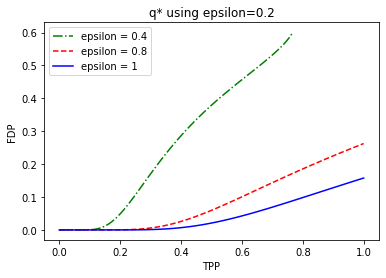

In [11]:
#example of plots regarding different values for delta and a fixed one for epsilon

epsilon = 0.2
deltas = [0.4, 0.8, 1]

for i in range(len(deltas)):
    for j in range (len(path)):
        q = fdrlasso(path[j], deltas[i], epsilon) #call fdrlasso
        q_list[j][i] = q

plt.plot(path, q_list[:,0], linestyle='-.',label='epsilon = ' + str(deltas[0]), color='g')
plt.plot(path, q_list[:,1], linestyle='dashed', label='epsilon = ' + str(deltas[1]), color='r')
plt.plot(path, q_list[:,2], label='epsilon = ' + str(deltas[2]), color='b')
plt.title('q* using epsilon=' + str(epsilon) )
plt.xlabel('TPP')
plt.ylabel('FDP')
plt.legend()
plt.show()

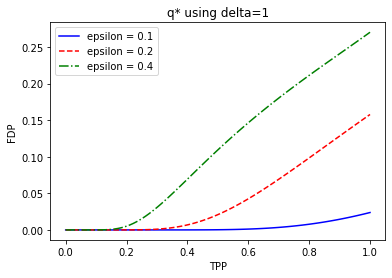

In [12]:
#example of plots regarding different values for epsilon and a fixed one for delta

epsilons = [0.1, 0.2, 0.4]
delta = 1

for i in range(len(epsilons)):
    for j in range (len(path)):
        q = fdrlasso(path[j], delta, epsilons[i]) #call fdrlasso
        q_list[j][i] = q

plt.plot(path, q_list[:,0], label='epsilon = ' + str(epsilons[0]), color='b')
plt.plot(path, q_list[:,1], linestyle='dashed', label='epsilon = ' + str(epsilons[1]), color='r')
plt.plot(path, q_list[:,2],  linestyle='-.', label='epsilon = ' + str(epsilons[2]), color='g')
plt.title('q* using delta=' + str(delta) )
plt.xlabel('TPP')
plt.ylabel('FDP')
plt.legend()
plt.show()